In [ ]:
import os
import random
from itertools import combinations

dataset_path = "D:/GP_Dr_inas/CASIA-Iris-Thousand"

subject_data = {}
for subject in os.listdir(dataset_path):
    subject_dir = os.path.join(dataset_path, subject)
    print(subject_dir)
    if os.path.isdir(subject_dir):
        subject_data[subject] = {
            "R": [],
            "L": []
        }
        for eye in ["R", "L"]:
            eye_dir = os.path.join(subject_dir, eye)
            if os.path.isdir(eye_dir):
                subject_data[subject][eye] = [os.path.join(eye_dir, img) for img in os.listdir(eye_dir)]

genuine_pairs = []
for subject, eyes in subject_data.items():
    for eye, images in eyes.items():
        genuine_pairs += list(combinations(images, 2))

impostor_pairs = []
subjects = list(subject_data.keys())
for _ in range(len(genuine_pairs)):  
    sub1, sub2 = random.sample(subjects, 2)
    eye1 = random.choice(["R", "L"])
    eye2 = random.choice(["R", "L"])
    img1 = random.choice(subject_data[sub1][eye1])
    img2 = random.choice(subject_data[sub2][eye2])
    impostor_pairs.append((img1, img2))

pairs = [(p[0], p[1], 1) for p in genuine_pairs] + [(p[0], p[1], 0) for p in impostor_pairs]
random.shuffle(pairs)

with open("pair2", "w") as f:
    for pair in pairs:
        f.write(f"{pair[0]} {pair[1]} {pair[2]}\n")

D:/GP_Dr_inas/CASIA-Iris-Thousand\100
D:/GP_Dr_inas/CASIA-Iris-Thousand\101
D:/GP_Dr_inas/CASIA-Iris-Thousand\102
D:/GP_Dr_inas/CASIA-Iris-Thousand\103
D:/GP_Dr_inas/CASIA-Iris-Thousand\104
D:/GP_Dr_inas/CASIA-Iris-Thousand\105
D:/GP_Dr_inas/CASIA-Iris-Thousand\106
D:/GP_Dr_inas/CASIA-Iris-Thousand\107
D:/GP_Dr_inas/CASIA-Iris-Thousand\108
D:/GP_Dr_inas/CASIA-Iris-Thousand\109
D:/GP_Dr_inas/CASIA-Iris-Thousand\110
D:/GP_Dr_inas/CASIA-Iris-Thousand\111
D:/GP_Dr_inas/CASIA-Iris-Thousand\112
D:/GP_Dr_inas/CASIA-Iris-Thousand\113
D:/GP_Dr_inas/CASIA-Iris-Thousand\114
D:/GP_Dr_inas/CASIA-Iris-Thousand\115
D:/GP_Dr_inas/CASIA-Iris-Thousand\116
D:/GP_Dr_inas/CASIA-Iris-Thousand\117
D:/GP_Dr_inas/CASIA-Iris-Thousand\118
D:/GP_Dr_inas/CASIA-Iris-Thousand\119
D:/GP_Dr_inas/CASIA-Iris-Thousand\120
D:/GP_Dr_inas/CASIA-Iris-Thousand\121
D:/GP_Dr_inas/CASIA-Iris-Thousand\122
D:/GP_Dr_inas/CASIA-Iris-Thousand\123
D:/GP_Dr_inas/CASIA-Iris-Thousand\124
D:/GP_Dr_inas/CASIA-Iris-Thousand\125
D:/GP_Dr_ina

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms, models
from PIL import Image
import random
import os

def is_image_file(filename):
    """Check if a file is an image based on its extension."""
    extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']
    return any(filename.lower().endswith(ext) for ext in extensions)

class IrisDataset(Dataset):
    def __init__(self, pairs_file, transform=None):
        self.pairs = []
        with open(pairs_file, 'r') as f:
            for line in f:
                img1, img2, label = line.strip().split()
                if is_image_file(img1) and is_image_file(img2):
                    self.pairs.append((img1, img2, int(label)))
        self.transform = transform

    def __getitem__(self, idx):
        img1_path, img2_path, label = self.pairs[idx]
        img1 = Image.open(img1_path).convert('L')  
        img2 = Image.open(img2_path).convert('L')


        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2, torch.tensor(label, dtype=torch.float32)


    def __len__(self):
        return len(self.pairs)

    

class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.feature_extractor = models.resnet18(pretrained=True)
        self.feature_extractor.fc = nn.Identity()  

        self.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )


    def forward_one(self, x):
        return self.feature_extractor(x)

    def forward(self, img1, img2):
        if img1.shape[1] == 1: 
            img1 = img1.repeat(1, 3, 1, 1)
            img2 = img2.repeat(1, 3, 1, 1)
        feat1 = self.forward_one(img1)
        feat2 = self.forward_one(img2)
        similarity = self.fc(torch.abs(feat1 - feat2))
        return similarity

if __name__ == "__main__":
    pairs_file = "pairs.txt"
    batch_size = 128
    num_epochs = 10
    learning_rate = 1e-3

    transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  
])



    dataset = IrisDataset(pairs_file, transform=transform)

    import matplotlib.pyplot as plt
    from PIL import Image

    labels = [label for _, _, label in dataset.pairs]
    num_positive = sum(labels)
    num_negative = len(labels) - num_positive

    print(f"Total Pairs: {len(labels)}")
    print(f"Positive Pairs (label=1): {num_positive}")
    print(f"Negative Pairs (label=0): {num_negative}")

    def plot_samples(dataset, num_samples=4):
        fig, axes = plt.subplots(2, num_samples, figsize=(12, 6))
        for i in range(num_samples):
            img1, img2, label = dataset[i]
            axes[0, i].imshow(img1.permute(1, 2, 0).numpy(),cmap='gray')  
            axes[1, i].imshow(img2.permute(1, 2, 0).numpy(),cmap='gray')
            axes[0, i].set_title(f"Label: {label}")
            axes[0, i].axis("off")
            axes[1, i].axis("off")
        plt.show()

    plot_samples(dataset)




    




c:\Users\lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ValueError: too many values to unpack (expected 3)

c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Loss: 0.1930
Validation Loss: 0.0834
Epoch [2/10], Loss: 0.0901
Validation Loss: 0.0778
Epoch [3/10], Loss: 0.0557
Validation Loss: 0.0536
Epoch [4/10], Loss: 0.0397
Validation Loss: 0.0455
Epoch [5/10], Loss: 0.0299
Validation Loss: 0.0334
Epoch [6/10], Loss: 0.0262
Validation Loss: 0.0400
Epoch [7/10], Loss: 0.0208
Validation Loss: 0.0373
Epoch [8/10], Loss: 0.0179
Validation Loss: 0.0333
Epoch [9/10], Loss: 0.0157
Validation Loss: 0.0277
Epoch [10/10], Loss: 0.0131
Validation Loss: 0.0238


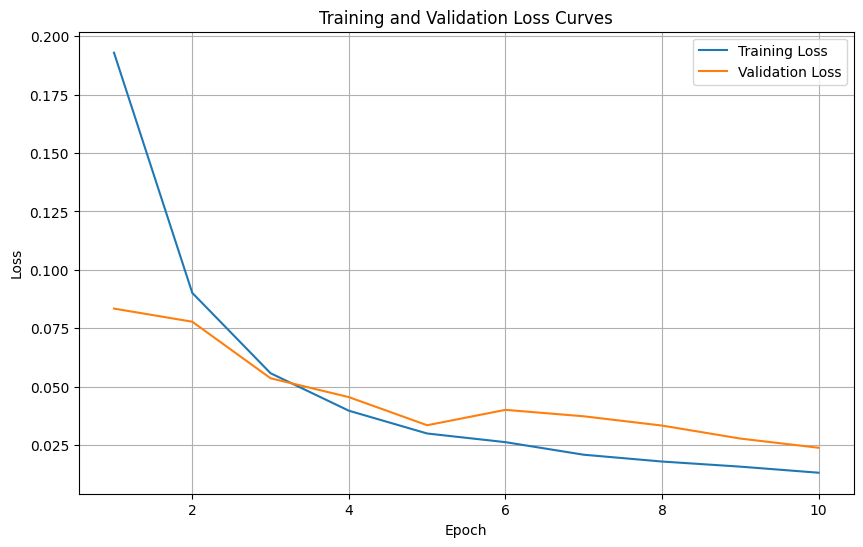

In [ ]:
validation_split=0.2
random_seed=42
dataset_size=len(dataset)
indices=list(range(dataset_size))
train_indices,val_indices=train_test_split(indices,test_size=validation_split,random_state=random_seed)
train_subset=torch.utils.data.Subset(dataset,train_indices)
val_subset=torch.utils.data.Subset(dataset,val_indices)
train_loader=DataLoader(train_subset,batch_size=batch_size,shuffle=True)
val_loader=DataLoader(val_subset,batch_size=batch_size,shuffle=False)

model = SiameseNetwork().cuda()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
model.train()

loss_history = []
val_loss_history = []


for epoch in range(num_epochs):
    total_train_loss = 0
    for img1, img2, label in train_loader:
        img1, img2, label = img1.cuda(), img2.cuda(), label.cuda()

        output = model(img1, img2).squeeze()
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
    
    avg_train_loss = total_train_loss / len(train_loader)
    loss_history.append(avg_train_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}")

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for img1, img2, label in val_loader:
            img1, img2, label = img1.cuda(), img2.cuda(), label.cuda()

            output = model(img1, img2).squeeze()
            loss = criterion(output, label)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_loss_history.append(avg_val_loss)
    print(f"Validation Loss: {avg_val_loss:.4f}")

torch.save(model.state_dict(), "siamese_model.pth")

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), loss_history, label="Training Loss")
plt.plot(range(1, num_epochs + 1), val_loss_history, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curves")
plt.legend()
plt.grid()
plt.show()


In [ ]:
# Load the model
model = SiameseNetwork().cuda()
model.load_state_dict(torch.load("iris/siamese_model.pth"))
model.eval()


NameError: name 'SiameseNetwork' is not defined

In [55]:
test_pairs_file = "test_dataset.txt"
test_dataset = IrisDataset(test_pairs_file, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)

all_labels = []
all_predictions = []

with torch.no_grad():
    for img1, img2, label in test_dataloader:
        img1, img2, label = img1.cuda(), img2.cuda(), label.cuda()

        output = model(img1, img2).squeeze()
        predictions = torch.sigmoid(output) > 0.5  

        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(label.cpu().numpy())

accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)
auc = roc_auc_score(all_labels, all_predictions)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1:.4f}")
print(f"Test AUC: {auc:.4f}")

report = classification_report(all_labels, all_predictions, target_names=["Negative", "Positive"])
print("\nClassification Report:")
print(report)


Test Accuracy: 0.9743
Test Precision: 0.9807
Test Recall: 0.9677
Test F1 Score: 0.9742
Test AUC: 0.9743

Classification Report:
              precision    recall  f1-score   support

    Negative       0.97      0.98      0.97      9005
    Positive       0.98      0.97      0.97      9000

    accuracy                           0.97     18005
   macro avg       0.97      0.97      0.97     18005
weighted avg       0.97      0.97      0.97     18005



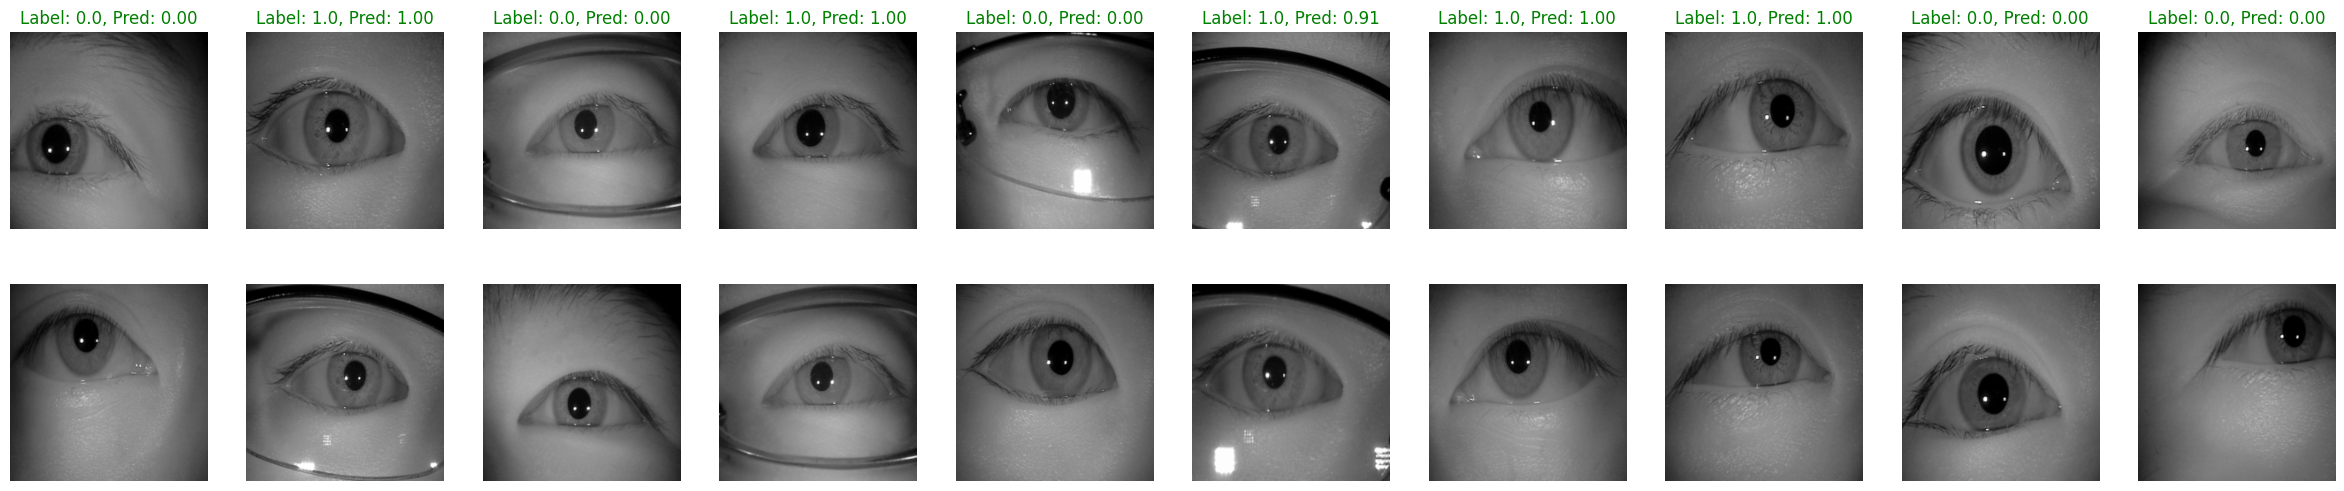

In [ ]:
def visualize_test_samples(dataset, model, num_samples=10):
    import matplotlib.pyplot as plt

    model.eval()
    fig, axes = plt.subplots(2, num_samples, figsize=(30, 6))
    
    for i in range(num_samples):
        img1, img2, label = dataset[i]
        img1, img2 = img1.unsqueeze(0).cuda(), img2.unsqueeze(0).cuda()
        
        with torch.no_grad():
            output = model(img1, img2).squeeze()
            prediction = torch.sigmoid(output).item()
        
        # Determine prediction match
        pred_label = int(prediction > 0.5)  # Assuming binary classification
        color = "green" if pred_label == label else "red"

        # Handle grayscale images (remove batch and channel dimensions)
        img1 = img1.squeeze(0).cpu().numpy()  # Remove batch dimension
        img2 = img2.squeeze(0).cpu().numpy()  # Remove batch dimension
        
        if img1.ndim == 3 and img1.shape[0] == 1:  # Grayscale image (1, H, W)
            img1 = img1.squeeze(0)  # Remove the channel dimension
        if img2.ndim == 3 and img2.shape[0] == 1:  # Grayscale image (1, H, W)
            img2 = img2.squeeze(0)  # Remove the channel dimension

        # Visualization
        axes[0, i].imshow(img1, cmap="gray")  # Use grayscale colormap
        axes[1, i].imshow(img2, cmap="gray")
        
        axes[0, i].set_title(f"Label: {label}, Pred: {prediction:.2f}", color=color)
        axes[0, i].axis("off")
        axes[1, i].axis("off")
    
    plt.show()

# Example usage
visualize_test_samples(test_dataset, model)


In [ ]:
import torch
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

def calculate_far_frr(model, dataloader):
    model.eval()
    true_labels = []
    scores = []

    with torch.no_grad():
        for img1, img2, label in dataloader:
            img1, img2 = img1.cuda(), img2.cuda()
            label = label.cuda()

            similarity = model(img1, img2).squeeze().cpu().numpy()
            scores.extend(similarity)  
            true_labels.extend(label.cpu().numpy())  

    fpr, tpr, thresholds = roc_curve(true_labels, scores)
    far = fpr  
    frr = 1 - tpr  

    plt.figure(figsize=(8, 6))
    plt.plot(thresholds, far, label="FAR (False Acceptance Rate)", color='red')
    plt.plot(thresholds, frr, label="FRR (False Rejection Rate)", color='blue')
    plt.xlabel("Threshold")
    plt.ylabel("Rate")
    plt.title("FAR and FRR vs Threshold")
    plt.legend()
    plt.grid()
    plt.show()

    return far, frr, thresholds



In [ ]:
import numpy as np
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)
far, frr, thresholds = calculate_far_frr(model, test_dataloader)

eer_threshold = thresholds[np.nanargmin(np.abs(far - frr))]
eer = far[np.nanargmin(np.abs(far - frr))]  

print(f"Equal Error Rate (EER): {eer:.4f}")
print(f"Threshold for EER: {eer_threshold-0.1:.4f}")

NameError: name 'DataLoader' is not defined